In [1]:
import pandas as pd
df = pd.read_csv('simpsons_dataset.csv')
df.shape

(158314, 2)

In [2]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [3]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [5]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [37]:
# !pip install spacy
import spacy
import re
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

In [17]:
# !spacy download en
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])  # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [18]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [23]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 5.01 mins


In [24]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85955, 1)

In [27]:
df_clean.head(1)

,clean
0,actually little disease magazine news show nat...


In [26]:
from gensim.models.phrases import Phrases, Phraser

In [28]:
sent = [row.split() for row in df_clean['clean']]

In [29]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [33]:
bigram = Phraser(phrases)

In [34]:
sentences = bigram[sent]

In [35]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

29694

In [38]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'come', 'right', 'look', 'want']

In [39]:
import multiprocessing

from gensim.models import Word2Vec

In [40]:
# import logging  # Setting up the loggings to monitor gensim
# logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [43]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [46]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [47]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.03 mins


In [48]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.97 mins


In [49]:
w2v_model.wv.most_similar(positive=["homer"])

[('gee', 0.7153589725494385),
 ('marge', 0.6979920268058777),
 ('bongo', 0.6910498142242432),
 ('crummy', 0.6812360286712646),
 ('depressed', 0.6680043339729309),
 ('eliza', 0.666283130645752),
 ('humiliate', 0.6595591306686401),
 ('jealous', 0.659451961517334),
 ('sweetheart', 0.6584876179695129),
 ('apu', 0.6547217965126038)]

In [50]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('council', 0.7028570175170898),
 ('easily', 0.6996117830276489),
 ('request', 0.6893356442451477),
 ('congratulation', 0.6825610995292664),
 ('select', 0.67575603723526),
 ('robert', 0.6755572557449341),
 ('recent', 0.6752681732177734),
 ('distract', 0.6732717752456665),
 ('threat', 0.6632421612739563),
 ('brief', 0.6559394598007202)]

In [51]:
w2v_model.wv.most_similar(positive=["marge"])

[('homie', 0.7007432579994202),
 ('homer', 0.6979919672012329),
 ('badly', 0.6776697635650635),
 ('snuggle', 0.664317786693573),
 ('darling', 0.6629724502563477),
 ('fault', 0.6514472365379333),
 ('attract', 0.6509073376655579),
 ('becky', 0.6501343846321106),
 ('grownup', 0.6469110250473022),
 ('humiliate', 0.6462141871452332)]

In [52]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.7634934186935425),
 ('hearing', 0.7606935501098633),
 ('mom', 0.7499101161956787),
 ('convince', 0.7304735779762268),
 ('mom_dad', 0.7213467955589294),
 ('chore', 0.7167285084724426),
 ('grownup', 0.7132783532142639),
 ('embarrassing', 0.712399423122406),
 ('homework', 0.7099063992500305),
 ('pay_attention', 0.6999633312225342)]

In [53]:
w2v_model.wv.similarity('maggie', 'baby')

0.6335378

In [56]:
import numpy as np

# List of words to calculate similarity for
words = ['maggie', 'baby', 'bart', 'nelson', 'tavern']

# Initialize an empty similarity matrix
similarity_matrix = np.zeros((len(words), len(words)))

# Calculate similarity for each pair of words
for i in range(len(words)):
    for j in range(len(words)):
        similarity = w2v_model.wv.similarity(words[i], words[j])
        similarity_matrix[i][j] = similarity

# Display the similarity matrix
print("Similarity Matrix:")
print(similarity_matrix)

Similarity Matrix:
[[1.         0.63353783 0.64405817 0.38113958 0.18879312]
 [0.63353783 1.         0.3573063  0.33608314 0.27211371]
 [0.64405817 0.3573063  1.         0.53939742 0.25211039]
 [0.38113958 0.33608314 0.53939742 1.         0.1082247 ]
 [0.18879312 0.27211371 0.25211039 0.1082247  1.        ]]


In [54]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

In [55]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('adopt', 0.5585996508598328),
 ('man', 0.5454488396644592),
 ('marry', 0.5428696870803833)]

## Exercise

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

In [112]:
class Settings():
    def __init__(self):
        # Hyper Parameter
        self.m = 3
        self.d = 10
        self.a = 0.01
        self.epoch = 100
        self.xmax = 1
        self.f_a = 0.75

In [135]:
class Data():

    def __init__(self, settings):
        self.m = settings.m
        self.make_corpus()
        self.co_occurrence_matrix()
        
    def make_corpus(self):
        text = "i love doing this project it is the thing which i enjoy the most"
        corpus = [text.split()]
        self.corpus = corpus
        
    def preparation(self):
        """ Making the frequency matrix"""
        self.word_freq = defaultdict(int)
        for sentence in self.corpus:
            for word in sentence:
                self.word_freq[word] += 1
        
        # self.words decide the index of all the words
        self.words = list(self.word_freq.keys())
        self.T = len(self.words)
        
        # word_index will give index for a given word and vice versa for index_word
        self.word_index = {word: idx for idx, word in enumerate(self.words)}
        self.index_word = {idx: word for idx, word in enumerate(self.words)}
        
    def co_occurrence_matrix(self):
        
        self.preparation()
        # In X each word have a particular row and column according to their index.
        # Xij - tabulate number of times word j appear in the contextof word i
        self.X = np.zeros((self.T, self.T))
        
        for sentence in self.corpus:
            
            sen_len = len(sentence)
            
            for i, c_word in enumerate(sentence):
                # target is the center word index
                # context is the context word index
                target = self.word_index[c_word]
                
                for j in range(max(0, i - self.m), min(sen_len, i + self.m + 1)):
                    
                    if j != i  and 0 <= j and j < sen_len:
                        context_word = sentence[j]
                        context = self.word_index[context_word]
                        self.X[target, context] += 1

In [136]:
class Model():
    
    def __init__(self, data, settings):
        self.settings = settings
        self.data = data
        self.X = self.data.X
        self.fun = np.vectorize(self.f)
        self.plot_initialise()
        self.prepare()
        
    def train(self):
        loss_values = []  # Create a list to store loss values
        # Iterating through the entire dataset epoch number of times
        
        for i in range(0, self.settings.epoch):
            
            delta = self.fun(self.X) * (self.U @ self.V - np.log(self.X + 1e-9))
            U_grad = delta @ self.V.T
            V_grad = self.U.T @ delta
            U_grad[:, self.settings.d] = 0 
            V_grad[self.settings.d, :] = 0
            
            # Updating U and V
            self.U -= self.settings.a * U_grad
            self.V -= self.settings.a * V_grad
            
            # Plotting Loss
            self.update_loss()
            loss_values.append(self.J)  # Append the current loss value
            
        # Plot with loss_values
        self.plot(loss_values)
 
    def prepare(self):
        self.data.preparation()
        self.U = np.random.uniform(-1, 1, (self.data.T, self.settings.d + 1))
        self.V = np.random.uniform(-1, 1, (self.settings.d + 1, self.data.T))
        for i in range(0, self.data.T):
            self.U[i, self.settings.d] = 1
            self.V[self.settings.d, i] = 1
            
    def f(self, x):
        if x > self.settings.xmax:
            return 1

        else:
            y = (x/self.settings.xmax)**self.settings.f_a
            return y
        
    def update_loss(self):
        J = self.fun(self.X) * ((self.U @ self.V - np.log(self.X + 1e-9)) ** 2)
        self.J = J.sum() / 2
    
    def plot(self, loss_values):  # Update the function to accept loss_values
        plt.plot(loss_values, label='Loss', color='red')
        plt.xlabel('Number of iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.pause(0.001)
        plt.show()
        
    def plot_initialise(self):
        
        style.use('dark_background')
        plt.figure()
        plt.xlabel('Number of iterations')
        plt.ylabel('Loss')
        
    def predict(self, word):
        
        index = self.data.word_index[word]
        w = self.U[index, :] + self.V[:, index] # TODO: Fix the error
        return w[1:-1] / 2

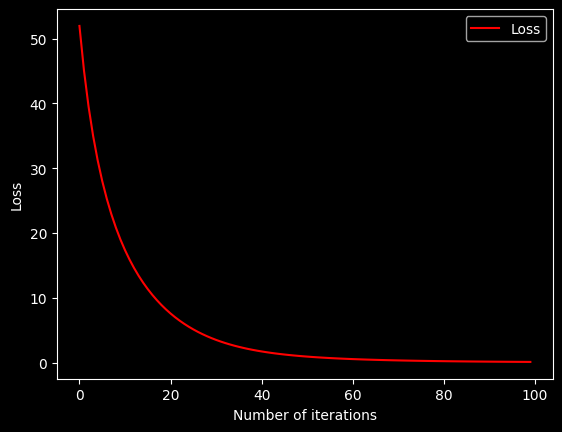

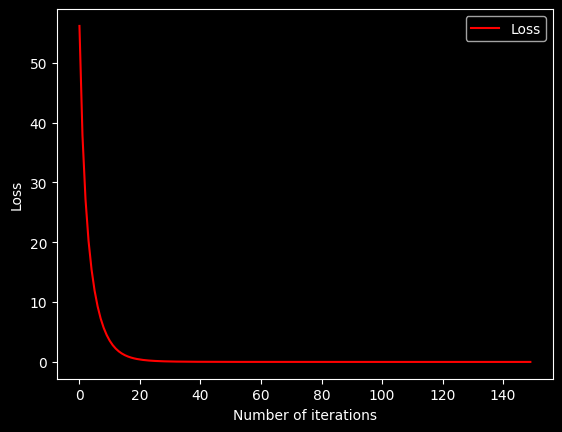

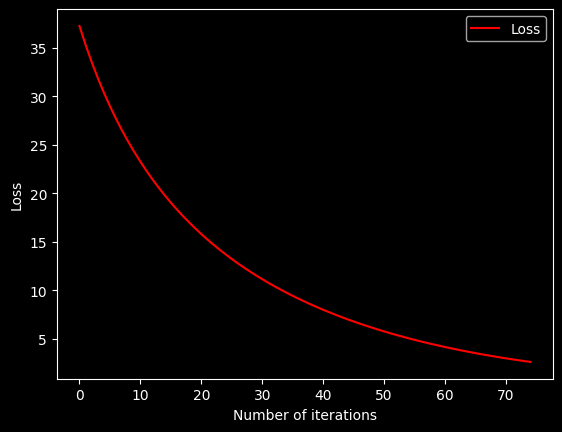

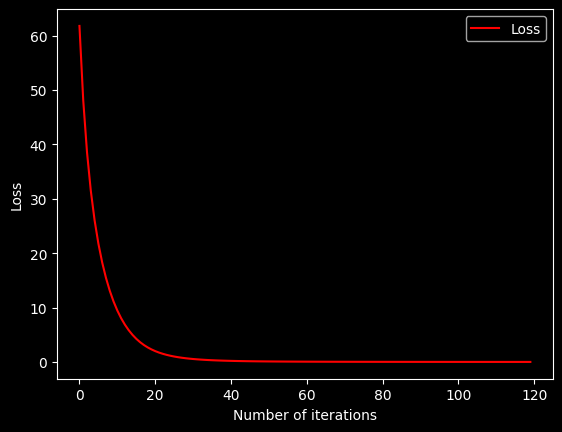

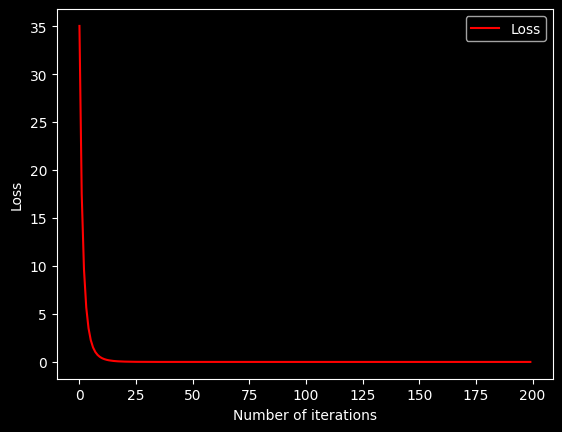

In [137]:
# Define a list of 5 different sets of hyperparameters
hyperparameters = [
    (3, 10, 0.01, 100, 1, 0.75),
    (5, 20, 0.02, 150, 1.5, 0.8),
    (2, 8, 0.005, 75, 0.8, 0.7),
    (4, 15, 0.015, 120, 1.2, 0.85),
    (6, 25, 0.03, 200, 1.8, 0.9)
]

# Create and train models for each set of hyperparameters in a for loop
models = []

for params in hyperparameters:
    settings = Settings()
    settings.m, settings.d, settings.a, settings.epoch, settings.xmax, settings.f_a = params
    
    data = Data(settings)
    model = Model(data, settings)
    model.train()
    
    models.append(model)


In [132]:
word = input('Enter the word whose vector you want to see.\n')
print(model.predict(word))

Enter the word whose vector you want to see.
enjoy
[ 0.13353718  0.37074838 -0.25067978  0.01935198  0.04351168  0.43397202
  0.2791325  -0.23418195 -0.39819862 -0.39095124  0.29181828  0.72413725
 -0.02517261  0.44298799 -0.5223915   0.11401599  0.54330857 -0.22421488
 -0.66757631 -0.17081834 -0.85658533 -0.2621365  -0.09755256 -0.52093748]
